In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [2]:
class model(nn.Module):
    def __init__(self,h,w):
        super(model,self).__init__()
        self.conv1=nn.Conv2d(3,32,(3,3))
        self.conv2=nn.Conv2d(32,64,(3,3))
        self.conv3=nn.Conv2d(64,64,(3,3))
        self.conv4=nn.Conv2d(64,64,(3,3))
        self.pool1=nn.MaxPool2d((3,3),stride = (2,2))
        self.pool2=nn.MaxPool2d((2,2),stride = (2,2))
        self.pool3=nn.MaxPool2d((2,2),stride = (2,2))
        self.h = int(h/8 -4)
        self.w = int(w/8 -4)
        self.mlp =nn.Linear(self.h*self.w*64,100)
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        self.act4 = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        # x = x.view(-1, self.h*self.w*64)
        x = x.reshape(-1, self.h * self.w * 64)
        print(x.shape)  # Add this before passing x to self.mlp

        x = self.mlp(x)
        x = self.act4(x)
        return x

In [3]:
image_path = "/Users/abhivansh/Desktop/CholecT50/videos/VID01/000054.png"
image = np.array(Image.open(image_path), np.float32) / 255.0
triplet_labels = ["grasper","grasp","gallbladder"]

Performing a simple forward pass on our untrained network for a test image


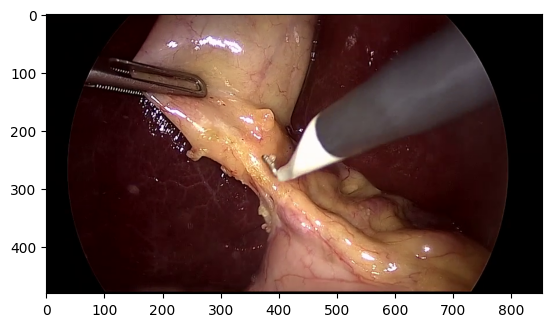


Prediction

torch.Size([1, 365568])
tensor([0.0109, 0.0159, 0.0322, 0.0030, 0.0000, 0.0019, 0.0000, 0.0000, 0.0171,
        0.0000, 0.0137, 0.0000, 0.0178, 0.0000, 0.0000, 0.0000, 0.0043, 0.0000,
        0.0163, 0.0000, 0.0059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0171, 0.0000,
        0.0136, 0.0000, 0.0204, 0.0000, 0.0017, 0.0112, 0.0000, 0.0000, 0.0121,
        0.0232, 0.0282, 0.0345, 0.0000, 0.0045, 0.0000, 0.0069, 0.0178, 0.0167,
        0.0019, 0.0216, 0.0273, 0.0250, 0.0248, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0000, 0.0000, 0.0063, 0.0000, 0.0034, 0.0014, 0.0275, 0.0000,
        0.0319, 0.0158, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0329,
        0.0000, 0.0000, 0.0110, 0.0131, 0.0067, 0.0056, 0.0058, 0.0000, 0.0000,
        0.0190, 0.0000, 0.0000, 0.0322, 0.0047, 0.0000, 0.0250, 0.0111, 0.0002,
        0.0179, 0.0000, 0.0231, 0.0000, 0.0107, 0.0000, 0.0367, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)

Label

['grasper', 'grasp', 'gallbladd

In [4]:
input_4d = np.expand_dims(image, axis=0)
input_4d = np.transpose(input_4d, [0, 3, 1, 2])
input_4d = torch.from_numpy(input_4d)
print('Performing a simple forward pass on our untrained network for a test image')
plt.imshow(image)
plt.show()
print('\nPrediction\n')
model  = model(480, 854)
print(model(input_4d)[0])
print('\nLabel\n')
print(triplet_labels)
# print('\nReadable label\n')
# for triplet_id in np.where(triplet_labels)[0]:
#   print(triplet_dict[triplet_id])

In [16]:
from matplotlib import patches
from glob import glob
import os
import json
import random

In [12]:
#spatial detection
imgs = sorted(glob('/Users/abhivansh/Desktop/CholecT50/bh25/sample-spatial/video/*.png'))
img_dict = {
  int(os.path.basename(path).split(".")[0]): path
  for path in imgs
}

with open("/Users/abhivansh/Desktop/CholecT50/bh25/sample-spatial/label.json") as f:
  annotations = {
    int(k): v
    for k, v in json.load(f).items()
  }

with open("/Users/abhivansh/Desktop/CholecT50/bh25/dict/instrument.txt") as f:
  instrument_buf = [
    lin.strip().split(":") for lin in f.readlines()
  ]
  instrument_table = {
    u[1]: int(u[0])
    for u in instrument_buf
  }

In [14]:
dict_path = "/Users/abhivansh/Desktop/CholecT50/bh25/dict"
with open(os.path.join(dict_path, 'triplet.txt'),'r') as f:
    triplet_info = f.readlines()
    triplet_dict = {}
    for l in triplet_info:
        triplet_id, triplet_label = l.split(":")
        triplet_dict[int(triplet_id)]= triplet_label.rstrip()

In [15]:
def one_random_detection():
  triplet_id = np.random.randint(0, 100)
  triplet_string = triplet_dict[triplet_id]
  tool_id = instrument_table[triplet_string.split(",")[0]]
  tool_prob = np.random.uniform(0, 0.6)
  bbox_x, bbox_y = np.random.uniform(0, 0.6, size=2)
  bbox_w = np.random.uniform(0.15, 0.4)
  bbox_h = np.random.uniform(0.15, 0.4)
  res = [
    triplet_id,
    tool_id,
    tool_prob,
    bbox_x,
    bbox_y,
    bbox_w,
    bbox_h
  ]
  return res

# Random detections for one image.
# This function is a placeholder for an object detector, hence the unused "img" argument.

def generate_random_detections(img):
  n_detect = np.random.randint(1, 3)
  detections = []
  for _ in range(n_detect):
    detections.append(one_random_detection())
  return detections

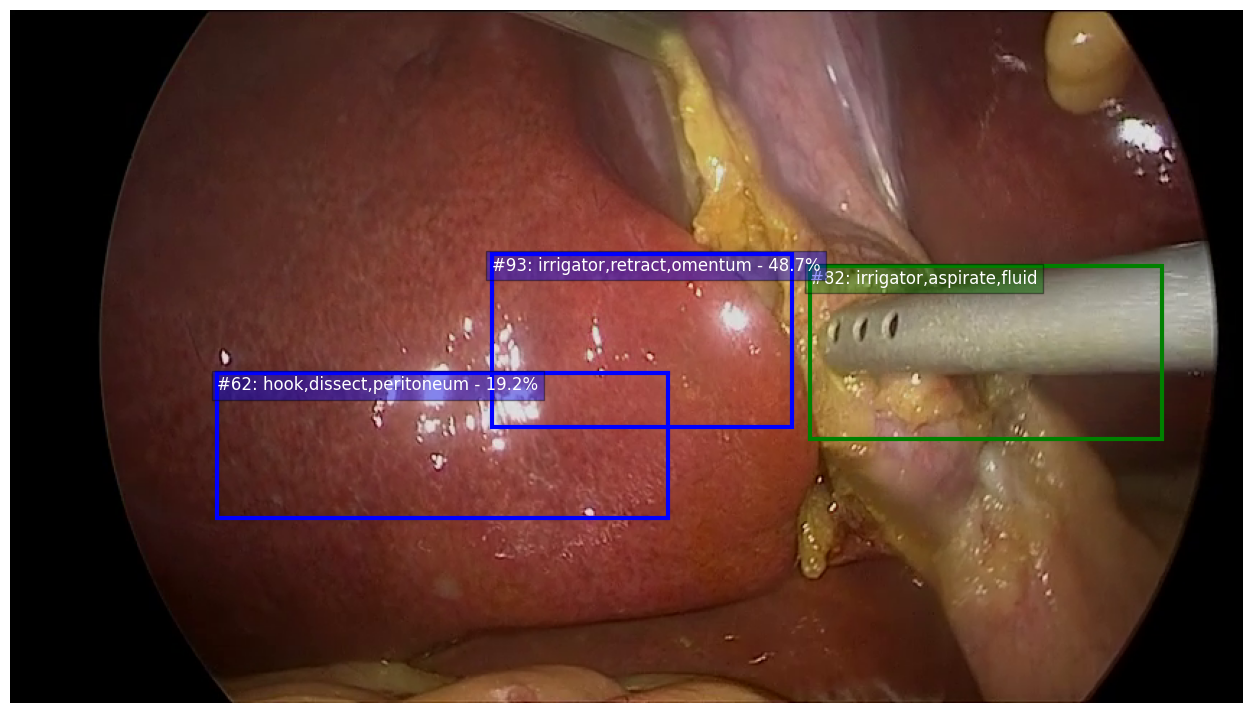

In [17]:
img_id = random.choice(list(annotations.keys()))

im = Image.open(img_dict[img_id])
true_w, true_h = im.size
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_axis_off()
ax.imshow(im)

im_gt = annotations[img_id]
im_pd = generate_random_detections(im)

# Visualize ground truth bboxes in green
for bbox in im_gt:
  ax.add_patch(
    patches.Rectangle(
      (
        bbox["instrument"][2] * true_w,
        bbox["instrument"][3] * true_h
      ),
      bbox["instrument"][4] * true_w,
      bbox["instrument"][5] * true_h,
      fill=False,
      edgecolor="green",
      lw=3
    )
  )
  ax.text(
    bbox["instrument"][2] * true_w,
    bbox["instrument"][3] * true_h + 12,
    "#{}: {}".format(
      bbox["triplet"],
      triplet_dict[bbox["triplet"]]
    ),
    color="white",
    fontsize=12,
    bbox={"facecolor": "green", "alpha": 0.4}
  )

# Visualize predicted bboxes in blue
for bbox in im_pd:
  ax.add_patch(
    patches.Rectangle(
      (
        bbox[3] * true_w,
        bbox[4] * true_h
      ),
      bbox[5] * true_w,
      bbox[6] * true_h,
      fill=False,
      edgecolor="blue",
      lw=3
    )
  )
  ax.text(
    bbox[3] * true_w,
    bbox[4] * true_h + 12,
    "#{}: {} - {:.01f}%".format(
      bbox[0],
      triplet_dict[bbox[0]],
      100 * bbox[2]
    ),
    color="white",
    fontsize=12,
    bbox={"facecolor": "blue", "alpha": 0.4}
  )

In [18]:
import ivtmetrics

In [19]:
half_0s = np.zeros(shape=[20,100], dtype=np.int64)
half_1s = np.ones(shape=[20,100], dtype=np.int64)

vid230_gt = np.concatenate((half_0s, half_1s), axis=0)
vid231_gt = np.concatenate((half_1s, half_0s), axis=0)

vid230_pd = np.random.random((40,100))
vid231_pd = np.random.random((40,100))

videos = [
  (vid230_gt, vid230_pd),
  (vid231_gt, vid231_pd)
]

recognize = ivtmetrics.Recognition(num_class=100)

In [21]:
for v in videos:
  for gt, pd in zip(*v):
    batch_gt = np.expand_dims(gt, axis=0)
    batch_pd = np.expand_dims(pd, axis=0)
    recognize.update(batch_gt, batch_pd)
  recognize.video_end()

print("Instrument mAP            : {}".format(
  recognize.compute_video_AP("i", ignore_null=True)["mAP"])
)
print("Verb mAP                  : {}".format(
  recognize.compute_video_AP("v", ignore_null=True)["mAP"])
)
print("Target mAP                : {}".format(
  recognize.compute_video_AP("t", ignore_null=True)["mAP"])
)
print("Instrument-Verb mAP       : {}".format(
  recognize.compute_video_AP("iv", ignore_null=True)["mAP"])
)
print("Instrument-Target mAP     : {}".format(
  recognize.compute_video_AP("it", ignore_null=True)["mAP"])
)
print("Instrument-Verb-Target mAP: {}".format(
  recognize.compute_video_AP("ivt", ignore_null=True)["mAP"])
)

Instrument mAP            : 0.5230914657937289
Verb mAP                  : 0.5434676442427415
Target mAP                : 0.5333033823779975
Instrument-Verb mAP       : 0.5374365288823462
Instrument-Target mAP     : 0.5407071704088919
Instrument-Verb-Target mAP: 0.5387262656002432


In [22]:
recognize.compute_video_AP("ivt", ignore_null=True)["AP"]


array([0.60193353, 0.51254052, 0.42845763, 0.55623474, 0.70817048,
       0.50504693, 0.50113399, 0.59671661, 0.62117607, 0.46712187,
       0.55447954, 0.49763894, 0.54248639, 0.75677366, 0.51306792,
       0.5045561 , 0.51343829, 0.60150583, 0.5973241 , 0.57768308,
       0.48613394, 0.5577733 , 0.47949165, 0.52167251, 0.55675244,
       0.62131431, 0.55566923, 0.50816928, 0.54335805, 0.50205318,
       0.59158472, 0.59525669, 0.58263422, 0.52216059, 0.54183953,
       0.63709828, 0.51523637, 0.56080755, 0.62428148, 0.49598537,
       0.50790669, 0.51595292, 0.54391883, 0.48736761, 0.48454157,
       0.52703649, 0.53541993, 0.53169469, 0.57067708, 0.51209887,
       0.5186041 , 0.49060073, 0.52257132, 0.55352662, 0.45810805,
       0.47966228, 0.67902415, 0.54893043, 0.56131804, 0.52749448,
       0.61438201, 0.49625497, 0.51861007, 0.51653153, 0.49207613,
       0.50792935, 0.50639181, 0.54335797, 0.54099905, 0.55257816,
       0.44507491, 0.67571984, 0.54987782, 0.46459995, 0.58393

In [23]:
def format_labels(label_dict):
  res = [
    int(label_dict["triplet"]),
    int(label_dict["instrument"][0]),
    int(label_dict["instrument"][1]),
    label_dict["instrument"][2],
    label_dict["instrument"][3],
    label_dict["instrument"][4],
    label_dict["instrument"][5]
  ]
  return res

images = [
  Image.open(img_dict[iid])
  for iid in annotations.keys()
]

vid_gt = [
  [format_labels(lb) for lb in frame_annotations]
  for frame_annotations in annotations.values()
]

vid_pd = [generate_random_detections(im) for im in images]

In [25]:
detect = ivtmetrics.Detection(num_class=100)

for frame_gt, frame_pd in zip(vid_gt, vid_pd):
  detect.update([frame_gt], [frame_pd])
detect.video_end()

print("Instrument-Verb-Target mAP: {}".format(
  detect.compute_video_AP("ivt")["mAP"])
)
print("Instrument-Verb-Target mean recall: {}".format(
  detect.compute_video_AP("ivt")["mRec"])
)
print("Instrument-Verb-Target mean precision: {}".format(
  detect.compute_video_AP("ivt")["mPre"])
)

Instrument-Verb-Target mAP: 0.0
Instrument-Verb-Target mean recall: 0.0
Instrument-Verb-Target mean precision: 0.0


In [26]:
vid230 = sorted(glob("CholecT50_sample/data/VID230/*.png"))
vid231 = sorted(glob("CholecT50_sample/data/VID231/*.png"))

videos = [
  ("VID230", vid230),
  ("VID231", vid231)
]

In [27]:
def random_triplet_prediction(img_in):
  n_batch = img_in.shape[0]
  return np.random.uniform(0, 1, (n_batch, 100))

def pack_results(list_in):
  res = {
    "triplet": list_in[0],
    "instrument": [
      list_in[1],
      list_in[2],
      list_in[3],
      list_in[4],
      list_in[5],
      list_in[6]
    ]
  }
  return res

result_dir = "results"
os.makedirs(result_dir, exist_ok=True)

for vidname, frame_list in videos:
  result_dict = {}
  for frame_path in frame_list:
    frame_id = os.path.basename(frame_path).split(".")[0]
    frame_data = np.array(Image.open(frame_path), np.float32)
    frame_data = np.expand_dims(frame_data, 0)
    recognition = random_triplet_prediction(frame_data)
    detection = generate_random_detections(frame_data)
    detection = [pack_results(l) for l in detection]
    result_dict[frame_id] = {
      "recognition": recognition.tolist(),
      "detection": detection
    }
  filename_out = os.path.join(
    result_dir,
    "{}.json".format(vidname)
  )
  with open(filename_out, "w") as f:
    json.dump(result_dict, indent=2, fp=f)